# Ranking

Find all the documents that contain all the words in the query and sort them by their relevance with regard to the query.

## Text processing

In [1]:
!pip install gensim

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import nltk
nltk.download('stopwords') #Dowload list of stopwords
nltk.download('punkt')

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import re #Library used to remove certain symbols / characters from a text
import random
import pandas as pd
import json
import unidecode
from datetime import datetime

import codecs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing
from gensim.models import Word2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Read datasets
tweet_document_ids_map = pd.read_csv(r'data/tweet_document_ids_map.csv', header = None, delimiter = "\t")

In [4]:
dict_mappings = tweet_document_ids_map.to_dict('list')
docs = dict_mappings[0]
tweets = dict_mappings[1]
doc_ids = {docs[i]: tweets[i] for i in range(len(docs))} #doc ids as keys, tweet ids as values
tweet_ids = {tweets[i]: docs[i] for i in range(len(docs))} #tweet ids as keys, doc ids as values

In [5]:
#Extract tweets from json file
with open("data/tw_hurricane_data.json", "r") as json_file:
    raw_tweets = [json.loads(tweet) for tweet in json_file]

In [6]:
raw_tweets[0]['user']

{'id': 28709505,
 'id_str': '28709505',
 'name': 'Suz👻',
 'screen_name': 'suzjdean',
 'location': 'Charleston, SC & DC',
 'description': 'MY #NATS #Caps #gamecocks family! I stand with #Ukraine 🇺🇦 IG: sjdean74',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 3811,
 'friends_count': 2868,
 'listed_count': 74,
 'created_at': 'Sat Apr 04 01:35:19 +0000 2009',
 'favourites_count': 320543,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': False,
 'statuses_count': 165706,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '0099B9',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme4/bg.gif',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme4/bg.gif',
 'profile_background_tile': False,
 'profile_image_url': 'http://pbs.twimg.com/profile_images/1513709638323257351/NuehKDmA_norma

In [7]:
tweets = {} #We create a dictionary to save all the needed tweets' information

for tweet in raw_tweets: #Iterate through all tweets in the json file
    dict_tweet = {} #Create a dictinary to save each individual tweet's information
    dict_tweet['Tweet'] = tweet['full_text'] #Store the text of the tweet
    dict_tweet['Full_text'] = tweet['full_text']
    dict_tweet['Date'] = tweet['created_at'] #Store the date of the tweet creation
    dict_tweet['Hashtags']= [] #Create an empty list to store the hashtags in the tweet
    for hashtag in tweet['entities']['hashtags']: #Iterate through the hashtag dictionary
        dict_tweet['Hashtags'].append(hashtag['text']) #Append the hashtag to the list
    user = {}
    user['Username'] = tweet['user']['screen_name'] #Store the username of the "writer"
    user['Followers'] = tweet['user']['followers_count']
    user['Following'] = tweet['user']['following']
    dict_tweet['User'] = user
    dict_tweet['Likes'] = tweet['favorite_count'] #Store the likes count of the tweet
    dict_tweet['Retweets'] = tweet['retweet_count'] #Store the retweets count of the tweet

    #We "create" the URL of each tweet and store it
    #https://twitter.com/screen_name/status/tweet_id
    dict_tweet['Url'] = 'https://twitter.com/'+dict_tweet['User']['Username']+'/status/'+tweet['id_str']

    dict_tweet['Doc_ID'] = tweet_ids[tweet['id']]
    #add tweet to dictionary tweets with the id as the tweet key
    tweets[tweet['id']] = dict_tweet

In [8]:
def clean_full_text(text):
    text = unidecode.unidecode(text)
    a = text.lower() #put everything in lowercase
    result = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",a) #cleaning data
    return result

In [9]:
def build_terms(line):
    

    stemmer = PorterStemmer()

    stop_words = set(stopwords.words("english"))
    line = line.lower()  #Convert to lowercase
    line = line.split()  # Tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  # eliminate the stopwords
    line = [x for x in line if x.startswith(("@", "https://", "$", '#')) != True]  # eliminate mentions
    line = [re.sub('[^a-z]+', '', x) for x in line] # since it's in english we don't have to worry about accents and such
    line = [stemmer.stem(word) for word in line] # perform stemming (HINT: use List Comprehension)
    return line

In [10]:
for tweet in tweets.keys():
    tweets[tweet]['Tweet'] = build_terms(tweets[tweet]['Tweet'])
    tweets[tweet]['Full_text'] = clean_full_text(tweets[tweet]['Full_text'])

In [11]:
def create_index(tweets):
    
    index = defaultdict(list)

    for tweet in tweets.keys():
        doc_ID = tweets[tweet]['Doc_ID']
        terms = build_terms(doc_ID+' '+' '.join(tweets[tweet]['Tweet']))  # docID + tweet_text
        
        current_page_index = {}

        for position, term in enumerate(terms): # terms contains docID + tweet_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [doc_ID, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index

In [12]:
index = create_index(tweets)

In [13]:
tweets[list(tweets.keys())[2570]]

{'Tweet': ['would', 'help', 'clean', 'up'],
 'Full_text': '  gen x  kerri0922 would help with  hurricaneian clean up   ',
 'Date': 'Fri Sep 30 15:46:52 +0000 2022',
 'Hashtags': ['HurricaneIan'],
 'User': {'Username': 'NewKerristartin', 'Followers': 267, 'Following': False},
 'Likes': 1,
 'Retweets': 0,
 'Url': 'https://twitter.com/NewKerristartin/status/1575874831190413312',
 'Doc_ID': 'doc_2571'}

In [14]:
def print_tweet_info(tweet):
    text = """id: {}, username: {}, text: {}, hashtags: {}, likes: {}, retweets: {}, url: {}""".format(tweet['Doc_ID'], tweet['User']['Username'], tweet['Full_text'], tweet['Hashtags'], tweet['Likes'],
                        tweet['Retweets'], tweet['Url'])
    return text


In [15]:
def retrieve_docs(docs, top_k):
    
    """
    Retrieve the documents in the required format
    
    Argument:
    docs -- collection of tweets
    top_k -- the number of tweets to retrieve
    
    Returns:
    doc_info - the collection of top tweets retrieved in the required format
    """
    doc_info = []
    for doc_id in docs[:top_k]:
        for t in tweets.keys():
            tweet = tweets[t]
            if(doc_id == tweets[t]['Doc_ID']):
                text = print_tweet_info(tweet)
                doc_info.append(text)
    return doc_info

In [16]:
def search(query, index):
    
    query = build_terms(query)
    docs = set()
    tweet_ids = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

## TF-IDF and OUR SCORE + cosine similarity

### TF-IDF + cosine similarity

Calculate for all terms in the query

In [17]:
def create_index_tfidf(tweets, num_documents):

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    idf = defaultdict(float)

    for tweet in tweets.keys():
        doc_ID = tweets[tweet]['Doc_ID']
        terms = build_terms(doc_ID+' '+' '.join(tweets[tweet]['Tweet']))  # docID + tweet_text

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [doc_ID, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)

    return index, tf, df, idf

In [18]:
start_time = time.time()
num_documents = len(tweets)
index, tf, df, idf = create_index_tfidf(tweets, num_documents)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TD-IDF index: 143.31 seconds


In [19]:
def rank_documents(terms, docs, index, idf, tf):
    
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would become 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_pred_score = [x[0] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, result_pred_score

In [20]:
def search_tf_idf(query, index, type = 'tfidf'):
    """
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = set([posting[0] for posting in index[query[0]]])
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs = [posting[0] for posting in index[term]]
            
            # docs = docs intersection term_docs
            docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    if type == 'tfidf':
        ranked_docs, pred_score = rank_documents(query, docs, index, idf, tf)
    elif type == 'our_score':
        ranked_docs, pred_score = rank_documents_our_score(query, docs, index, idf, tf, our_score)
    elif type == 'bm25':
        ranked_docs, pred_score = rank_documents_BM25(query, docs)
    else:
        ranked_docs, pred_score = rank_documents_w2v(query, docs)

    return ranked_docs, pred_score

In [ ]:
query = "no light"
ranked_docs, _ = search_tf_idf(query, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))

formated = retrieve_docs(ranked_docs, top)

count = 1
for doc in formated:
    print('Result', count, ':\n\n', doc + '\n')
    count += 1

No results found, try again

Top 10 results out of 0 for the searched query:



### Our-score + cosine similarity

In [22]:
def create_index_tfidf_our_score(tweets, num_documents):

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    idf = defaultdict(float)
    our_score = defaultdict(int)
    for tweet in tweets.keys():
        doc_ID = tweets[tweet]['Doc_ID']
        terms = build_terms(doc_ID+' '+' '.join(tweets[tweet]['Tweet']))  # docID + tweet_text

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [doc_ID, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)

        # from here the code varies from create_index_tfidf
        score = 0
        #if the user has more followers the score will be higher 
        if tweets[tweet]['User']['Followers'] > 0:
            score += tweets[tweet]['Likes'] / np.log(tweets[tweet]['User']['Followers'])
            score += tweets[tweet]['Retweets'] / np.log(tweets[tweet]['User']['Followers'])
        # if the tweet is recent as 1 year ago
        if int(tweets[tweet]['Date'][-4:]) >= datetime.now().year - 1:
            score += 0.05

        our_score[doc_ID] = score
        

    return index, tf, df, idf, our_score


In [23]:
start_time = time.time()
num_documents = len(tweets)
index, tf, df, idf, our_score = create_index_tfidf_our_score(tweets, num_documents)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

/tmp/ipykernel_413/765139297.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  score += tweets[tweet]['Likes'] / np.log(tweets[tweet]['User']['Followers'])
/tmp/ipykernel_413/765139297.py:53: RuntimeWarning: invalid value encountered in double_scalars
  score += tweets[tweet]['Retweets'] / np.log(tweets[tweet]['User']['Followers'])
/tmp/ipykernel_413/765139297.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  score += tweets[tweet]['Retweets'] / np.log(tweets[tweet]['User']['Followers'])
/tmp/ipykernel_413/765139297.py:52: RuntimeWarning: invalid value encountered in double_scalars
  score += tweets[tweet]['Likes'] / np.log(tweets[tweet]['User']['Followers'])
Total time to create the TD-IDF index: 160.62 seconds


In [24]:
def rank_documents_our_score(terms, docs, index, idf, tf, our_score):
    
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would become 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] + our_score[doc]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_pred_score = [x[0] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index, 'our_score')
    #print ('\n'.join(result_docs), '\n')
    return result_docs, result_pred_score

In [25]:
query = "bad storm"
ranked_docs, _ = search_tf_idf(query, index, 'our_score')
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))

formated = retrieve_docs(ranked_docs, top)

count = 1
for doc in formated:
    print('Result', count, ':\n\n', doc + '\n')
    count += 1


Top 10 results out of 4 for the searched query:

Result 1 :

 id: doc_646, username: RoddyKnowles, text: peak tide wasn t too bad in downtown charleston  this was at noon  wentworth and gadsden got a lot deeper in 2015 18 storms   chswx  hurricaneian  , hashtags: ['chswx', 'HurricaneIan'], likes: 1, retweets: 0, url: https://twitter.com/RoddyKnowles/status/1575910270701948928

Result 2 :

 id: doc_2785, username: nynjconnweather, text: the storm surge between charleston  and myrtle beach looks like it could get bad  seek higher ground if you live along the coast here   ncwx  scwx  hurricaneian  , hashtags: ['NCwx', 'SCwx', 'HurricaneIan'], likes: 0, retweets: 1, url: https://twitter.com/nynjconnweather/status/1575871747563278339

Result 3 :

 id: doc_3754, username: heyyo1227, text: hey     we just went through  hurricaneian and we lost power  still out and of course our food in the refrigerator is going bad  also can t work until we figure things out  just hoping you can help out  ou

### BM25

In [26]:
from rank_bm25 import *

In [27]:
tweets[list(tweets.keys())[0]]

{'Tweet': ['keep', 'spin', 'us', '', 'pmgo', 'away', 'alreadi'],
 'Full_text': 'so this will keep spinning over us until 7 pm   go away already   hurricaneian  ',
 'Date': 'Fri Sep 30 18:39:08 +0000 2022',
 'Hashtags': ['HurricaneIan'],
 'User': {'Username': 'suzjdean', 'Followers': 3811, 'Following': False},
 'Likes': 0,
 'Retweets': 0,
 'Url': 'https://twitter.com/suzjdean/status/1575918182698979328',
 'Doc_ID': 'doc_1'}

In [28]:
def rank_documents_BM25(terms, docs):
    tokens_corpus = [tweets[doc_ids[doc_id]]['Tweet'] for doc_id in docs]
    bm25 = BM25Okapi(tokens_corpus)
    bm25_score = bm25.get_scores(terms)
    bm25_scores = {}
    for i in range(len(docs)):
        curr_bm25 = bm25_score[i]
        doc = docs[i]
        
        try:
            length_hashtag = 1 + np.log(len(tweets[doc_ids[doc]]['Tweet'])/len(tweets[doc_ids[doc]]['Hastags']))
        except:
            length_hashtag = 1
        if tweets[doc_ids[doc]]['Likes'] > 0:
            num_likes = 1 + np.log(int(tweets[doc_ids[doc]]['Likes']))
        else: 
            num_likes = 1
        if tweets[doc_ids[doc]]['Retweets'] > 0:
            num_retweets = 1 + np.log(int(tweets[doc_ids[doc]]['Retweets']))
        else:
            num_retweets = 1
        score = curr_bm25 * length_hashtag * num_likes * num_retweets
        bm25_scores[doc] = score

    bm25_scores = {k: v for k, v in sorted(bm25_scores.items(), key=lambda item: item[1], reverse=True)}
    result_docs = [bm for bm in bm25_scores.keys()]
    result_pred_score = [bm25_scores[bm] for bm in bm25_scores.keys()]    

    return result_docs, result_pred_score
        

In [29]:
index = create_index(tweets)
query = "hurricane tide"
ranked_docs, _ = search_tf_idf(query, index, 'bm25')
top = 10

print(ranked_docs)

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))

formated = retrieve_docs(ranked_docs, top)

count = 1
for doc in formated:
    print('Result', count, ':\n\n', doc + '\n')
    count += 1

['doc_1213']

Top 10 results out of 1 for the searched query:

Result 1 :

 id: doc_1213, username: BillKarins, text: looks like water levels peaking in  myrtlebeach area  surge is still coming in but it is being negated by the quickly dropping high tide cycle  surge is now at 5 23 feet   passing hurricane isaias 2020    4 26 feet   now 3rd highest recorded since 1957  hurricaneian  , hashtags: ['MyrtleBeach', 'HurricaneIan'], likes: 11, retweets: 5, url: https://twitter.com/BillKarins/status/1575902735710375938



# Word2vec + cosine similarity

In [30]:
index = create_index(tweets) #use the original index

In [31]:
# Transforming the text of all tweets in a txt format
textfile = open("file.txt", "w")
for tweet in tweets.values():
    for word in tweet['Tweet']:
        for letter in word:
            textfile.write(letter + " ")
textfile.close()

In [32]:
# Using the function for preprocessing recommended by towardsdatascience.com
def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


def prepare_for_w2v(filename_from, filename_to, lang):
    raw_text = codecs.open(filename_from, "r", encoding='windows-1251').read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            print(preprocess_text(sentence.lower()), file=f)

In [33]:
# Training the model
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, window=5, min_count=5, workers=multiprocessing.cpu_count())

In [34]:
import gensim
from sklearn.manifold import TSNE

In [35]:
# Creating the tweets 2d scatterplot
prepare_for_w2v('file.txt', 'file1.txt', 'english')
model_ak = train_word2vec('file1.txt')

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


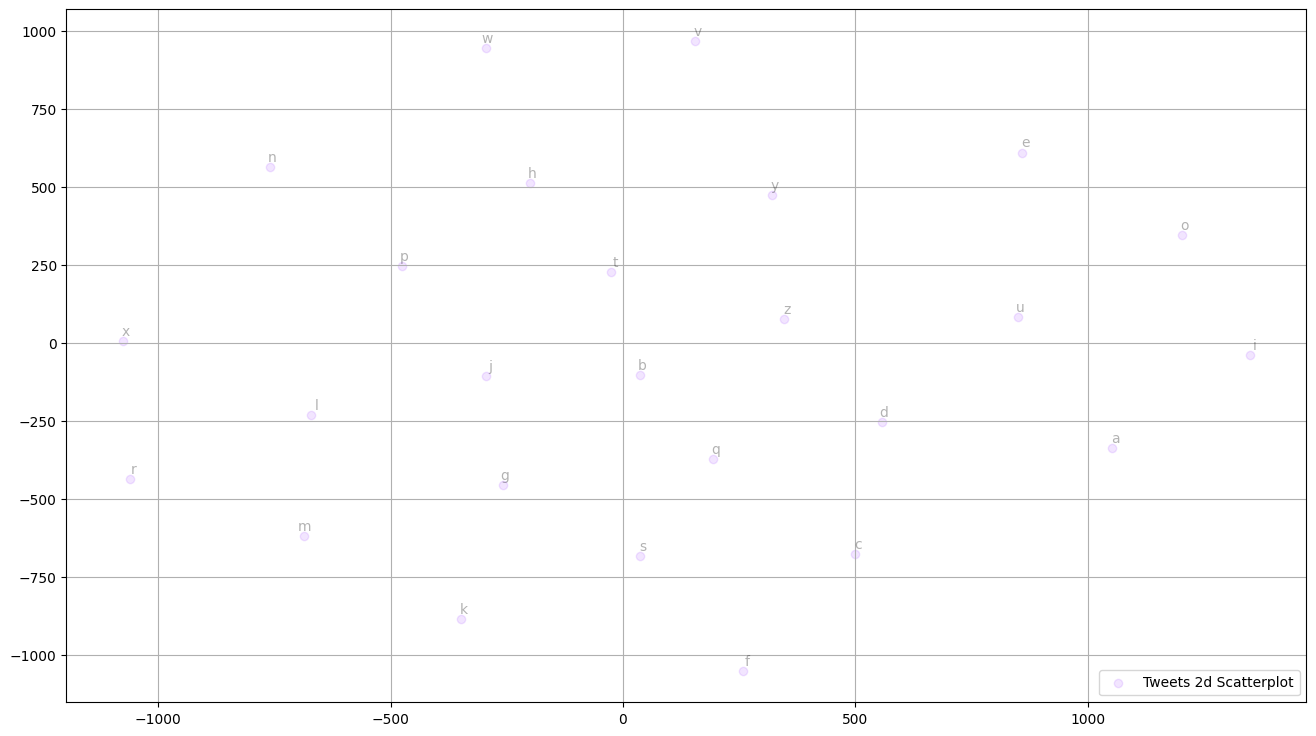

In [37]:
words_ak = []
embeddings_ak = []
for word in model_ak.wv.key_to_index:
# for word in (model_ak.wv.index_to_key):
    embeddings_ak.append(model_ak.wv[word])
    words_ak.append(word)
embeddings_ak = np.array(embeddings_ak)

tsne_ak_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom')
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Tweets 2d Scatterplot', embeddings_ak_2d,words_ak, a=0.1)

In [38]:
#Creating the list of preprocessed tweets
all_tweets = []
for i in tweets.keys():
     all_tweets.append(tweets[i]['Full_text'])

In [39]:
def get_embedding_w2v(doc_tokens):
    embeddings = []
    for tok in doc_tokens:
        if tok in model_ak.wv.index_to_key:
            embeddings.append(model_ak.wv.get_vector(tok))
        else:
            embeddings.append(np.random.rand(100))
    # mean the vectors of individual words to get the vector of the document
    return np.mean(embeddings, axis=0)

average_vector = []
keys = list(tweets)
for i in range(len(all_tweets)):
    lista = []
    ids = tweets[keys[i]]['Doc_ID']
    tweet = get_embedding_w2v(all_tweets[i])
    lista.extend([ids, tweet])
    average_vector.append(lista)

In [40]:
def rank_documents_w2v(terms, docs):
    # We are interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # We call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary

    query_vector = np.asarray(get_embedding_w2v(terms))

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):    
            if doc in docs:
                lst2 = [item[0] for item in average_vector]
                index1 = lst2.index(doc)
                doc_vectors[doc] = average_vector[index1][1]
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_pred_score = [x[0] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index, 'word2vec')

    return result_docs,result_pred_score

In [41]:
index = create_index(tweets)
query = "keep warm"
ranked_docs, _ = search_tf_idf(query, index, 'word2vec')
top = 10

print(ranked_docs)

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))

formated = retrieve_docs(ranked_docs, top)


count = 1
for doc in formated:
    print('Result', count, ':\n\n', doc + '\n')
    count += 1

['doc_2940', 'doc_3036']

Top 10 results out of 2 for the searched query:

Result 1 :

 id: doc_2940, username: jenniferclmn, text:       florida is surrounded by warm water  i mean  these strong hurricanes will only keep happening   again and again and again  climate change  global warming   fossil fuel emissions trapped in earth s atmosphere  so florida  you know  you know   climatechange  hurricaneian  , hashtags: ['ClimateChange', 'HurricaneIan'], likes: 0, retweets: 0, url: https://twitter.com/jenniferclmn/status/1575870066637185026

Result 2 :

 id: doc_3036, username: jenniferclmn, text:    ian just destroyed  strong hurricanes and tornadoes will keep happening  again and again  climate change  trapped fossil fuel emissions in earth s atmosphere is heating up our planet  warmer atmosphere causes warm water    hurricaneian  florida  southcarolina     , hashtags: ['HurricaneIan', 'Florida', 'SouthCarolina'], likes: 0, retweets: 0, url: https://twitter.com/jenniferclmn/status/15758

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a8d1a678-5677-4c27-b5af-590183e3d260' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>